#Introduction
This python code is for the MaskDetection Function of IN3060/INM460 Computer Vision (PRD2 A 2023/24) Coursework.

## Google Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CV2024-CW-230048952-LYHuang'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Models', 'Code', 'CW_Dataset', 'Video', 'test_function.ipynb']


## Library import

In [ ]:
# for accessing and preprocessing the dataset
import cv2
from collections import Counter
from sklearn.model_selection import train_test_split

# HOG
from skimage.feature import hog
from skimage import exposure
import numpy as np

# SIFT
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans

# SVM
from sklearn import svm, metrics
from joblib import dump, load

# MLPs
from sklearn.neural_network import MLPClassifier

# CNNs
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
torch.cuda.manual_seed(46)
torch.manual_seed(46)

# Model Performance and images output
import matplotlib.pyplot as plt
import random

import warnings
warnings.filterwarnings("ignore", "Precision and F-score are ill-defined*")

%matplotlib inline

# MaskDetection Function Prepare

Before building the main function for mask detection, we would build some smaller functions.

In this section, there will be five parts including, test dataset prepare, HOG+SVM evaluation, SIFT+MLP evaluation, CNN model evaluation, and in the last will perform the MaskDetection Function combining all four parts above.


## Dataset


In [ ]:
# Functions to read images and labels stored as dictionary with filename
def read_labels(path):
    labels = {}
    for file in os.listdir(path):
        if file.endswith('.txt'):
            with open(os.path.join(path, file), 'r') as f:
                labels[file.split('.')[0]] = f.read()
    return labels

def read_images(path):
    images = {}
    for file in os.listdir(path):
        if file.endswith('.jpeg'):
            img = cv2.imread(os.path.join(path, file))
            images[file.split('.')[0]] = img
    return images

# Function to preprocess images
def preprocess_images(images):
    processed_images = []
    for image in images:
        resized_image = cv2.resize(image, (32, 32)) # resize to 32x32
        normalized_image = resized_image.astype('float32') / 255.0 # convert to folat and normalise
        processed_images.append(normalized_image)
    return processed_images

# Function to import and preprocess provided dataset
def testset_import_preprocess(path_to_testset):
    ## filepath for test dataset
    image_test_dir = os.path.join(path_to_testset, 'images')
    label_test_dir = os.path.join(path_to_testset, 'labels')

    # Read test labels and images
    labels_test = read_labels(label_test_dir)
    images_test = read_images(image_test_dir)

    # Store two lists for images and labels
    test_images = []
    test_labels = []
    for filename, label in labels_test.items():
        if filename in images_test:
            test_images.append(images_test[filename])
            test_labels.append(label)

    # Preprocess images
    test_images_transform = preprocess_images(test_images)

    return test_images_transform, test_labels

label_text = { '0': "No mask", '1': "Mask", '2': "Mask incorrect"}

## HOG + SVM

In [ ]:
## Functions for HOG + SVM in test dataset
def HOG_extract(images):

    # Extract HOG features from images
    images_hog = []
    for image in images:
        features, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualize=True, channel_axis=2)
        hog_image = exposure.equalize_hist(hog_image)
        images_hog.append(features)

    # Flatten the HOG features
    images_hog = np.array(images_hog)

    return images_hog

def HOGwSVM_4randomImage(classifier, images, labels):

    # Generate 4 random indices
    random_indices = random.sample(range(len(images)), 4)

    # Plot the images with true and predicted labels
    plt.figure(figsize=(8, 4))
    plt.suptitle('Four Random Images with HOG + SVM')
    for i, idx in enumerate(random_indices, 1):
        image = images[idx]  # Retrieve image
        true_label = labels[idx]  # True label
        hog_features = HOG_extract([image])  # Extract HOG features
        predicted_label = classifier.predict(hog_features)[0]  # Predict label

        true_label_text = label_text.get(true_label)
        predicted_label_text = label_text.get(predicted_label)

        # Plot the image
        plt.subplot(1, 4, i)
        plt.imshow(image)
        plt.title(f'True: {true_label_text}\nPredicted: {predicted_label_text}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## SIFT + MLP

In [ ]:
def SIFTwMLP_4randomImage(classifier, images, labels, kmeans):

    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # Generate 4 random indices
    random_indices = random.sample(range(len(images)), 4)

    # Plot the images with true and predicted labels
    plt.figure(figsize=(8, 4))
    plt.suptitle('Four Random Images with SIFT + MLP')
    for i, idx in enumerate(random_indices, 1):
        image = images[idx]  # Retrieve image
        true_label = labels[idx]  # True label
        true_label_text = label_text.get(true_label)

        # SIFT feature
        hist_list = []
        img = img_as_ubyte(color.rgb2gray(image))
        kp, des = sift.detectAndCompute(img, None)

        if des is not None:
            hist = np.zeros(30)
            idx = kmeans.predict(des)

            for j in idx:
                hist[j] = hist[j] + (1 / len(des))

            hist_list.append(hist)

        else:
            hist_list.append(None)

        if hist_list:
            hist_array = np.vstack(hist_list)
            predicted_label = classifier.predict(hist_array)[0]  # Predict label
            predicted_label_text = label_text.get(predicted_label)

        else:
            predicted_label_text = 'No SIFT feature'


        # Plot the image
        plt.subplot(1, 4, i)
        plt.imshow(image)
        plt.title(f'True: {true_label_text}\nPredicted: {predicted_label_text}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## CNN

In [ ]:
## CNNs architectures
# CNNs with one layer of conventional layer
class CNN_1(nn.Module):
    def __init__(self, hidden_size, kernel_size):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=hidden_size,
                               kernel_size=kernel_size, stride=1, padding=int((kernel_size-1)/2))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(hidden_size * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# CNNs with two layers of conventional layers
class CNN_2(nn.Module):
    def __init__(self, hidden_size, kernel_size):
        super(CNN_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=hidden_size,
                               kernel_size=kernel_size, stride=1, padding=int((kernel_size-1)/2))
        self.conv2 = nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size,
                               kernel_size=kernel_size, stride=1, padding=int((kernel_size-1)/2))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(hidden_size * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def CNN_4randomImage(classifier, images, labels):
    # Generate 4 random indices
    random_indices = random.sample(range(len(images)), 4)

    # Plot the images along with true and predicted labels
    plt.figure(figsize=(8, 4))
    plt.suptitle('Four Random Images with CNN')
    for i, idx in enumerate(random_indices, 1):
        image = images[idx]  # Retrieve image
        true_label = labels[idx]  # True label
        true_label_text = label_text.get(true_label)

        # convert image to tensor and normalise with means and stds
        data_means = [0.485, 0.456, 0.406]
        data_stds = [0.229, 0.224, 0.225]

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=data_means, std=data_stds)
        ])
        img_tensor = transform(image).unsqueeze(0)  # Add batch dimension

        # Prediction
        classifier.eval()
        with torch.no_grad():
            output = classifier(img_tensor)
            _, predicted_label = torch.max(output, 1)
            predicted_label = predicted_label.item()  # Convert to Python scalar

        predicted_label_text = label_text.get(str(predicted_label))

        # Plot the image
        plt.subplot(1, 4, i)
        plt.imshow(image)
        plt.title(f'True: {true_label_text}\nPredicted: {predicted_label_text}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# MaskDetection Function

**The model types:**
1. "HOG + SVM"
2. "SIFT + MLP"
3. "CNN"

***Note that the "GOOGLE_DRIVE_PATH" must the direction of the folder that have all models and dataset***

Functions would be copied into py file for test_function reuse.

In [ ]:
def MaskDetection(path_to_testset, model_type):
    # Load and preproccess the testset
    test_images_transform, test_labels = testset_import_preprocess(path_to_testset)

    if model_type == "HOG + SVM":
        HOGwSVM_4randomImage(HOGwSVM_classifier, test_images_transform, test_labels)

    elif model_type == "SIFT + MLP":
        SIFTwMLP_4randomImage(SIFTwMLP_classifier, test_images_transform, test_labels, kmeans)

    elif model_type == "CNN":
        CNN_4randomImage(CNN_classifier, test_images_transform, test_labels)

    else:
        print("Doesn't recognise the model type, please retry.")

Show the result

In [ ]:
# define path to test set
test_path = os.path.join(GOOGLE_DRIVE_PATH, "CW_Dataset/test")

# Load the trained models
HOGwSVM_classifier = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models/HOGwSVM_classifier.joblib'))
SIFTwMLP_classifier = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models/SIFTwMLP_classifier.joblib'))
kmeans = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models/kmeans_SIFT.joblib'))
CNN_classifier = torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'Models/CNN_classifier.pth'))

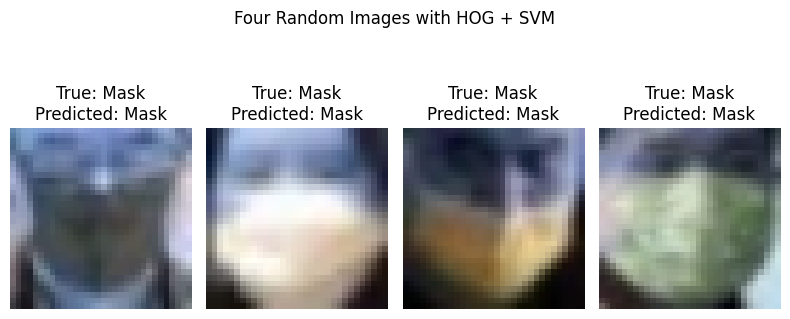

In [ ]:
# "HOG + SVM"
MaskDetection(test_path, "HOG + SVM")

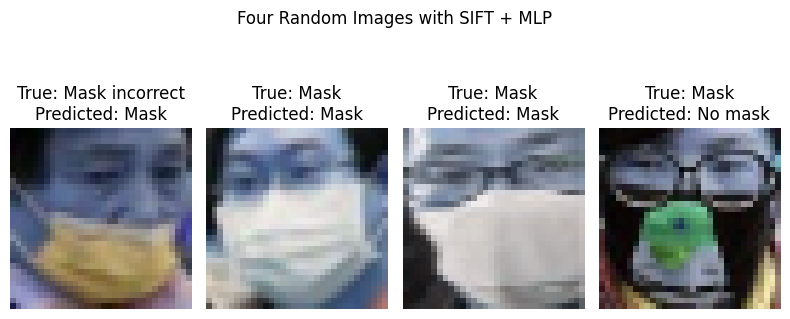

In [ ]:
# "SIFT + MLP"
MaskDetection(test_path, "SIFT + MLP")

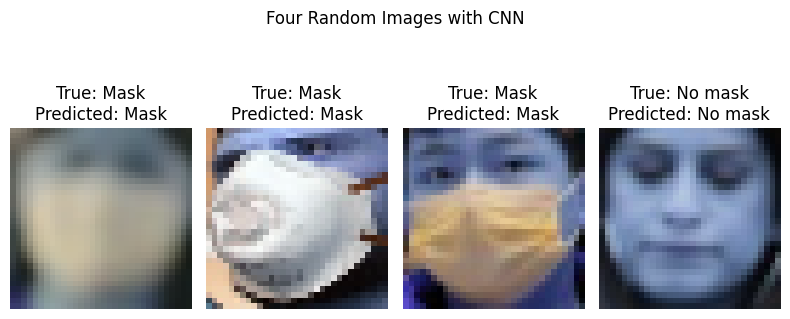

In [ ]:
# "CNN"
MaskDetection(test_path, "CNN")